# Connect to Database

In [7]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [8]:
engine = create_engine('postgresql://amy@localhost:5432/amy')

# Summary Metrics

## Overall Metrics
- Total number of agencies
- Percent of agencies with paratransit
- Percent of agencies that reported modified or no service at least once
- Percent of agencies that reported collecting modified or no fares at least once

In [97]:
query = """
    WITH response_rates AS (
        SELECT DATE_TRUNC('week',week) AS week
        , COUNT(DISTINCT agency)::FLOAT/208 AS response_rate
        FROM cal_itp_surveys_final
        GROUP BY 1
    )
    SELECT COUNT(DISTINCT c.agency) AS num_agencies
    , COUNT(DISTINCT CASE WHEN mode_fixed_route THEN c.agency END) AS num_fixed_route
    , COUNT(DISTINCT CASE WHEN mode_ada_paratransit THEN c.agency END)::FLOAT/COUNT(DISTINCT c.agency)
        AS percent_paratransit
    , COUNT(DISTINCT CASE WHEN operating IN ('modified','no-service') THEN c.agency END)::FLOAT/COUNT(DISTINCT c.agency)
        AS percent_service_modified
    , COUNT(DISTINCT CASE WHEN fare_collection IN('no','no-in-practice','modified') THEN c.agency END)::FLOAT/COUNT(DISTINCT c.agency)
        AS percent_fare_modified
    , AVG(response_rate) AS avg_response_rate
    , MIN(response_rate) AS min_response_rate
    , MAX(response_rate) AS max_response_rate
    FROM cal_itp_surveys_final c
    JOIN response_rates a ON DATE_TRUNC('week',a.week) = DATE_TRUNC('week',c.week)
    WHERE 1=1
"""

data = pd.read_sql_query(query, con=engine)

In [98]:
data.head()

,num_agencies,num_fixed_route,percent_paratransit,percent_service_modified,percent_fare_modified,avg_response_rate,min_response_rate,max_response_rate
0,208,143,0.682692,0.793269,0.576923,0.191816,0.009615,0.413462


In [55]:
query = """
    SELECT 
    'Paratransit Only' AS category
    , COUNT(DISTINCT CASE WHEN mode_ada_paratransit 
        AND NOT mode_fixed_route
        THEN agency END) AS total
    FROM cal_itp_surveys_final
    GROUP BY 1
    
    UNION ALL 
    
    SELECT 
    'Fixed-Route Only' AS category
    , COUNT(DISTINCT CASE WHEN mode_fixed_route 
        AND NOT mode_ada_paratransit
        THEN agency END) AS total
    FROM cal_itp_surveys_final
    GROUP BY 1
    
    UNION ALL
    
    SELECT 'Fixed-Route and Paratransit' AS category
    , COUNT(DISTINCT CASE WHEN mode_fixed_route 
        AND mode_ada_paratransit
        THEN agency END) AS total
    FROM cal_itp_surveys_final
    GROUP BY 1
"""

data = pd.read_sql_query(query, con=engine)

In [56]:
data.head()

,category,total
0,Paratransit Only,73
1,Fixed-Route Only,84
2,Fixed-Route and Paratransit,79


In [84]:
sns.set_theme(style="white")
plt.rcParams['figure.figsize']=(10,8)

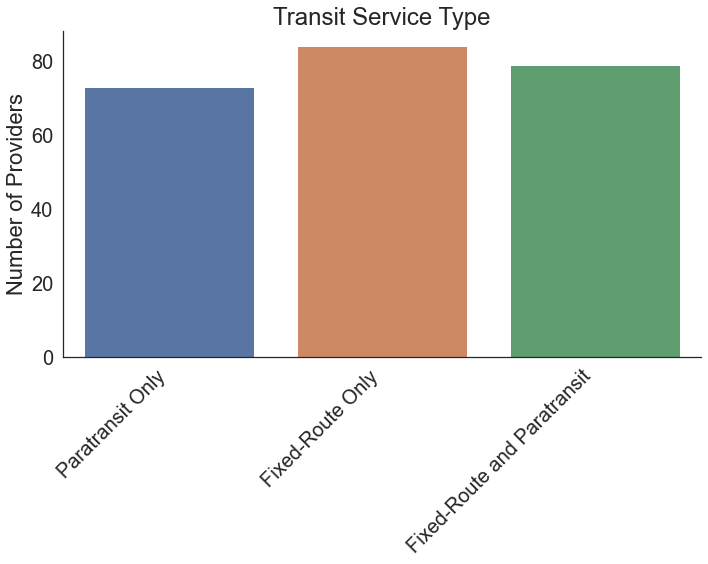

In [85]:
# Transportation Type

ax = sns.barplot(data=data, 
                  x="category", y="total")
ax.set_title("Transit Service Type",
            fontsize=24)
ax.set_xlabel("")
ax.set_ylabel("Number of Providers", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45,horizontalalignment='right')
plt.tight_layout()
plt.savefig('provider_type.png')
plt.show()

In [105]:
query = """
    SELECT 
    'Hand Sanitizer' AS category
    , SUM(CASE WHEN LOWER(preventative_measures) LIKE '%hand sanitiz%' 
        THEN 1 END) AS total
    FROM cal_itp_surveys_final
    WHERE 1=1
    AND mode_fixed_route
    GROUP BY 1
    
    UNION ALL 
    
    SELECT 
    'Social Distancing' AS category
    , SUM(CASE WHEN LOWER(preventative_measures) LIKE '%social distanc%' 
        THEN 1 END) AS total
    FROM cal_itp_surveys_final
    WHERE 1=1
    AND mode_fixed_route
    GROUP BY 1
    
    UNION ALL
    
    SELECT 
    'Masks' AS category
    , SUM(CASE WHEN LOWER(preventative_measures) LIKE '% mask%' 
        THEN 1 END) AS total
    FROM cal_itp_surveys_final
    WHERE 1=1
    AND mode_fixed_route
    GROUP BY 1
"""

data = pd.read_sql_query(query, con=engine)

In [106]:
data.head()

,category,total
0,Hand Sanitizer,199
1,Social Distancing,266
2,Masks,393


In [107]:
sns.set_theme(style="white")
plt.rcParams['figure.figsize']=(10,8)

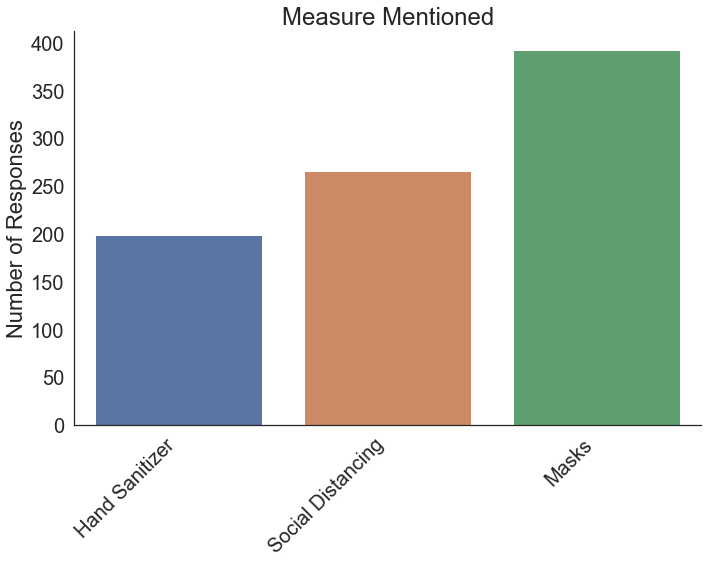

In [108]:
# Preventative Measures

ax = sns.barplot(data=data, 
                  x="category", y="total")
ax.set_title("Measure Mentioned",
            fontsize=24)
ax.set_xlabel("")
ax.set_ylabel("Number of Responses", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45,horizontalalignment='right')
plt.tight_layout()
plt.savefig('measures.png')
plt.show()

## Weekly Metrics
- Weekly response rate
- Weekly percent paratransit only
- Weekly percent fixed route only
- Weekly percent both

In [47]:
query = """
    SELECT DATE_TRUNC('week',week) AS week
    , (COUNT(DISTINCT agency)::FLOAT/208)*100 AS response_rate
    , (COUNT(DISTINCT CASE WHEN mode_ada_paratransit AND NOT mode_fixed_route THEN agency END)::FLOAT/COUNT(DISTINCT agency))*100
        AS percent_paratransit_only
    , (COUNT(DISTINCT CASE WHEN mode_fixed_route AND NOT mode_ada_paratransit THEN agency END)::FLOAT/COUNT(DISTINCT agency))*100
        AS percent_fixed_route_only
    , (COUNT(DISTINCT CASE WHEN mode_fixed_route AND mode_ada_paratransit THEN agency END)::FLOAT/COUNT(DISTINCT agency))*100
        AS percent_paratransit_fixed_route
    FROM cal_itp_surveys_final
    WHERE 1=1
    GROUP BY 1
"""

data = pd.read_sql_query(query, con=engine)

In [48]:
data.head()

,week,response_rate,percent_paratransit_only,percent_fixed_route_only,percent_paratransit_fixed_route
0,2020-03-02 00:00:00-08:00,4.326923,11.111111,44.444444,44.444444
1,2020-03-09 00:00:00-07:00,6.730769,21.428571,28.571429,50.000000
2,2020-03-16 00:00:00-07:00,8.173077,23.529412,41.176471,41.176471
3,2020-03-23 00:00:00-07:00,41.346154,31.395349,27.906977,33.720930
4,2020-03-30 00:00:00-07:00,29.326923,29.508197,34.426230,37.704918


In [ ]:
sns.set_theme(style="white")
plt.rcParams['figure.figsize']=(18,6)

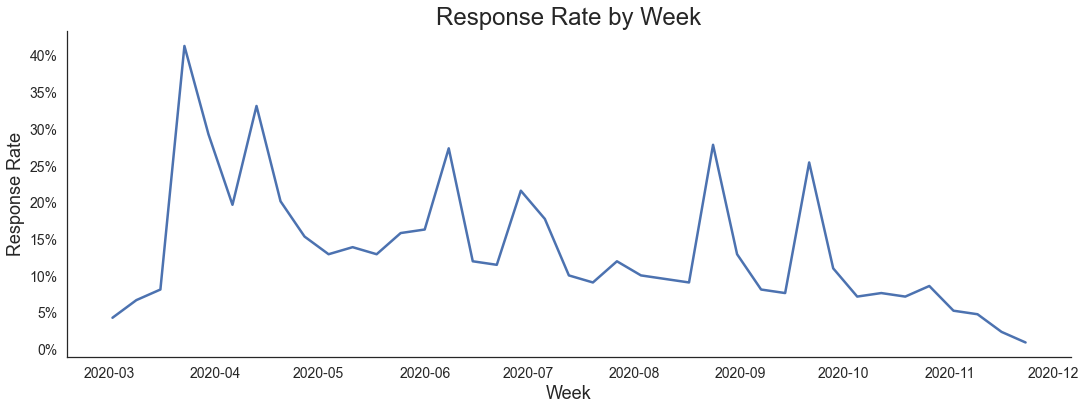

In [52]:
# Response Rate by Week

ax = sns.lineplot(data=data, 
                  x="week", y="response_rate", 
                  linewidth=2.5, 
                  legend=False)
ax.set_title("Response Rate by Week",
            fontsize=24)
ax.set_xlabel("Week", fontsize=18)
ax.set_ylabel("Response Rate", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fmt = '{x:,.0f}%'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
plt.savefig('response_rate.png')
plt.show()

## Agency Metrics (WIP)

In [32]:
agency = 'Eastern Sierra Transit Authority'

### Revenue Loss

In [88]:
query = """
    WITH loss AS (
        SELECT DISTINCT DATE_TRUNC('week',week) AS week
        , agency
        , REPLACE(revenue_loss_through_reporting_week,',','')::FLOAT AS loss
        
        FROM cal_itp_surveys_final
    
        WHERE 1=1 
        AND agency = '{0}'
        AND revenue_loss_through_reporting_week IS NOT NULL
    )
    SELECT DISTINCT week
    , loss
    , agency
    
    FROM loss 
    ORDER BY agency, week
""".format(agency)

data = pd.read_sql_query(query, con=engine)

In [89]:
sns.set_theme(style="white")
plt.rcParams['figure.figsize']=(18,6)

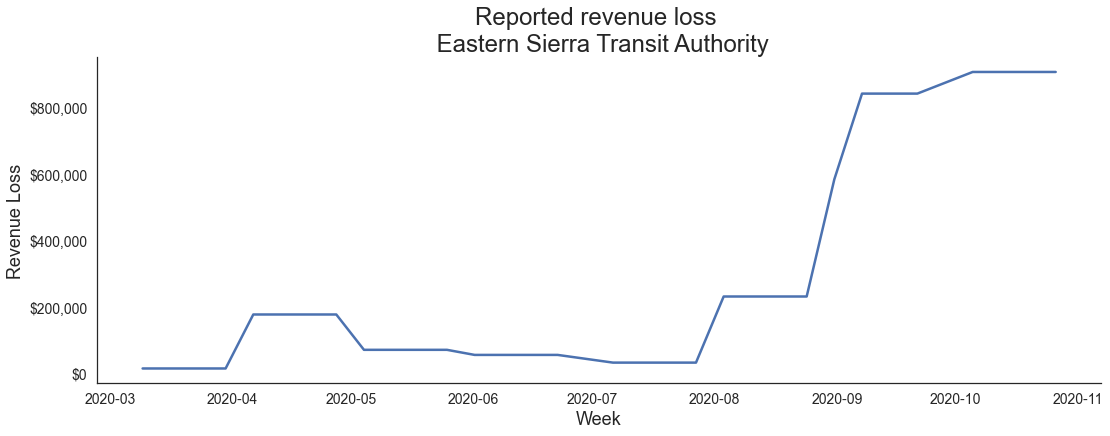

In [90]:
ax = sns.lineplot(data=data, 
                  x="week", y="loss", hue='agency', 
                  linewidth=2.5, 
                  legend=False)
ax.set_title("Reported revenue loss \n " + agency,
            fontsize=24)
ax.set_xlabel("Week", fontsize=18)
ax.set_ylabel("Revenue Loss", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.savefig('revenue_loss.png')
plt.show()